In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numba import jit
import anndata

%matplotlib inline

## import scRNA-seq data

In [3]:
nova_data = sc.read_h5ad("/home/ubuntu/mouse_lymph_node/nova/nova_final_data.h5ad")

OSError: Unable to open file (unable to open file: name = '/home/ubuntu/mouse_lymph_node/nova/nova_final_data.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [92]:
# remove some cell types
mapping = {"Mature B cells": "B cells", 
           "Ifit3-high B cells": "B cells",
           "Cycling B/T cells": "B cells",
            "Plasma B cells": "NA",
        "Neutrophils": "NA",
           "Ly6-high monocytes": "NA",
           "Cxcl9-high monocytes": "NA",
          "Macrophages": "NA",
          "cDC1s":"NA",
           "NK cells":"NA",
           "GD T cells":"NA",
           "cDC2s":"NA",
           "Monocytes":"NA",
           "pDCs":"NA"
          }

res = []
for x in nova_data.obs["cell_types"]:
    local = x
    if x in mapping:
        local = mapping[x]
    res.append(local)
    
nova_data.obs["broad_cell_types"] = res
nova_data = nova_data[nova_data.obs["broad_cell_types"] != "NA"].copy()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [93]:
nova_data.obs["broad_cell_types"].value_counts()

B cells          8359
CD8 T cells      3268
CD4 T cells      2043
Tregs             390
Migratory DCs     299
Name: broad_cell_types, dtype: int64

## filter some genes

In [94]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(nova_data, min_counts=10)

nova_data.layers["counts"] = nova_data.X.copy()

sc.pp.normalize_total(nova_data, target_sum=10e4)
sc.pp.log1p(nova_data)
nova_data.raw = nova_data

sc.pp.highly_variable_genes(
    nova_data,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


## learn dictionary of intra cell type variation

In [95]:
from sklearn.decomposition import SparsePCA, NMF, PCA

In [96]:
# transformer = NMF(n_components=5, random_state=0, alpha=5, l1_ratio=1.)
# transformer = PCA(n_components=5)
transformer = {}
for t, ct in enumerate(np.unique(nova_data.obs["broad_cell_types"])):
    print(t, ct)
    transformer[t] = SparsePCA(n_components=4, random_state=0, alpha=5)
    transformer[t].fit(nova_data.X[nova_data.obs["broad_cell_types"] == ct].A[:, :])

n_celltypes = np.unique(nova_data.obs["broad_cell_types"]).shape[0]
n_genes = transformer[0].components_.shape[1]
n_latent = transformer[0].components_.shape[0]
mean_ = np.zeros(shape=(n_celltypes, n_genes))
components_ = np.zeros(shape=(n_celltypes, n_latent, n_genes))
for t in transformer.keys():
    mean_[t] = transformer[t].mean_
    components_[t] = transformer[t].components_
    
np.savez('grtruth_PCA.npz', mean_=mean_, components_=components_)

0 B cells
1 CD4 T cells
2 CD8 T cells
3 Migratory DCs
4 Tregs


In [101]:
grtruth_PCA = np.load('grtruth_PCA.npz')
mean_, components_ = grtruth_PCA["mean_"], grtruth_PCA["components_"]

For each cell type:
$$\log(1 + \lambda_{ng}) = \mu + W^\top z$$  
$$x_{ng} \sim \textrm{Poisson}\left(\lambda_{ng}\right)$$


### small iid example
simulating from iid prior on the latent space and looking at a PCA to identify variations

In [592]:
v_latent = 5
z = np.random.normal(0, v_latent, (1000, 4))
mean = mean_[0] + np.dot(z, components_[0])
mean[mean < 0] = 0
transformed_mean = np.expm1(mean)
samples = np.random.poisson(lam=transformed_mean)

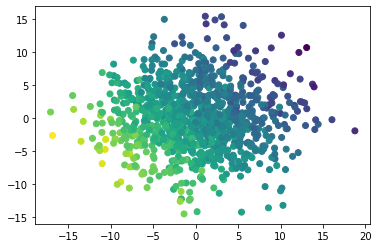

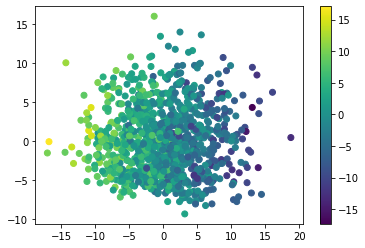

In [593]:
proj = PCA(n_components=3).fit_transform(np.log(1 + samples))
plt.scatter(proj[:, 0], proj[:, 1], c=z[:, 0])
plt.show()
plt.scatter(proj[:, 0], proj[:, 2], c=z[:, 0])
plt.colorbar()

## work around the spatial data to create a smooth spatial prior

In [582]:
# st_adata = sc.read_h5ad("/home/ubuntu/tumor/spatial/save/joint.h5ad")
# locations = st_adata.obsm["location"]

In [583]:
locations = np.mgrid[-10:10:0.5, -10:10:0.5].reshape(2,-1).T

In [584]:
# get the kernel bandwidth for simulation
from scipy.spatial.distance import pdist, squareform
dist_table = pdist(locations)
bandwidth = np.median(dist_table)

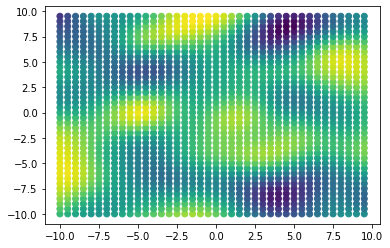

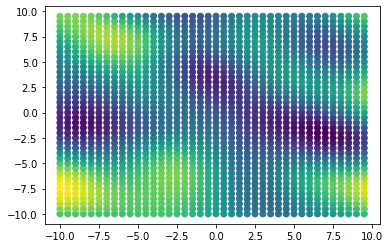

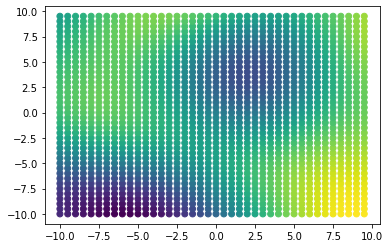

In [585]:
for lamb_ in (0.1, 0.2, 0.8):
    K = np.exp(- squareform(dist_table)**2 / (lamb_*bandwidth**2))
    N = K.shape[0]
    observation = np.random.multivariate_normal(np.zeros(N), K)
    plt.scatter(locations[:, 0], locations[:, 1], c=observation)
    plt.show()

### get cell types proportion for every spot

In [586]:
# get six cell types
C = 5
lambd_ = 0.1
temperature = 1
# sample from the multivariate GP
K = np.exp(- squareform(dist_table)**2 / (lambd_*bandwidth**2))
sample = np.random.multivariate_normal(np.zeros(N), K, size=C).T
# get through softmax
e_sample = np.exp(sample / temperature)
freq_sample = e_sample / np.sum(e_sample, 1)[:, np.newaxis]

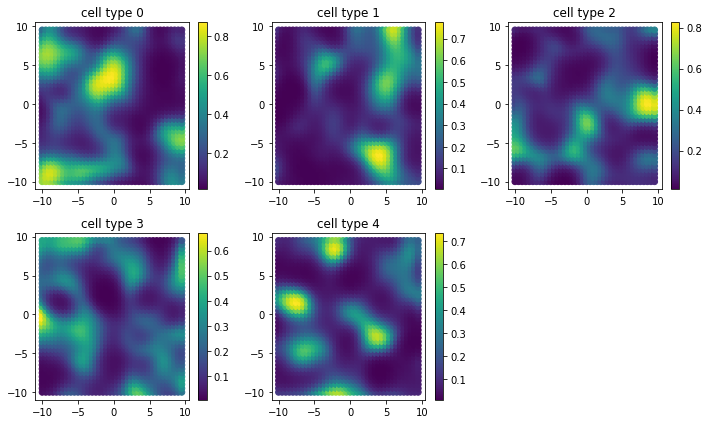

In [587]:
plt.figure(figsize=(10,6))
for i in range(0, 5):
    plt.subplot(231 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=freq_sample[:, i])
    plt.title("cell type "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

### get gamma for every spot

In [696]:
# get six cell types
D = 4
lambd_ = 0.5
scaling_factor = 15
# form the multivariate GP covariance
K = scaling_factor * np.exp(- squareform(dist_table)**2 / (lambd_*bandwidth**2))

# get latent variable for each cell types
# sample from the multivariate GP
gamma = np.random.multivariate_normal(np.zeros(N), K, size=(D)).T
# of course, the random walk can go in crazy places of the latent space. So we need to normalize it somehow
# for i in range(C):
#     sample[:, i, :] -= sample[:, i, :].mean(0)
#     sample[:, i, :] = np.dot(np.linalg.inv(sqrtm(np.cov(sample[:, i, :].T))), sample[:, i, :].T).T
#     sample[:, i, :] /= (1 +  10) * sample[:, i, :].std(0)

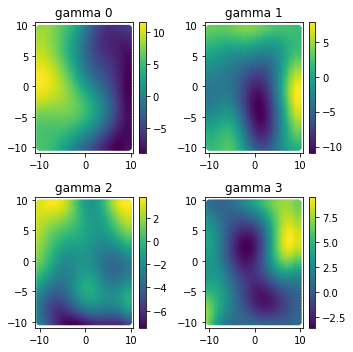

In [697]:
plt.figure(figsize=(5,5))
for i in range(D):
    plt.subplot(221 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=gamma[:, i])
    plt.title("gamma "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

### simulate 100 cells or so, inside of every spot of the grid

In [698]:
K = 100

In [699]:
def categorical(p, n_samples):
    size = list(p.shape[:-1])
    size.insert(0, n_samples)
    return (p.cumsum(-1) >= np.random.uniform(size=size)[..., None]).argmax(-1).T

In [700]:
@jit(nopython=True)
def get_mean_normal(cell_types, gamma, mean_, components_):
    """
    cell_types: (n_spots, n_cells)
    gamma: (n_spots, n_cells, n_latent)
    
    return: samples: (n_spots, n_cells, n_genes)
    """
    # extract shapes
    n_spots = gamma.shape[0]
    n_cells = gamma.shape[1]
    n_latent = gamma.shape[2]
    n_genes = components_[0].shape[1]
    
    mean_normal = np.zeros((n_spots, n_cells, n_genes))
    for spot in range(n_spots):
        for cell in range(n_cells):
            mean_normal[spot, cell] = mean_[cell_types[spot, cell]]
            c = components_[cell_types[spot, cell]]
            g = np.expand_dims(gamma[spot, cell], 0)
            mean_normal[spot, cell] += np.dot(g, c)[0]
    return mean_normal

In [701]:
cell_types_sc = categorical(freq_sample, K)
gamma_sc = gamma[:, None, :].repeat(K, axis=1)
location_sc = locations[:, None, :].repeat(K, axis=1)
mean_normal = get_mean_normal(cell_types_sc, gamma_sc, mean_, components_)
mean_normal[mean_normal < 0] = 0
transformed_mean = np.expm1(mean_normal)
samples = np.random.poisson(lam=transformed_mean)

In [769]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [703]:
sc_anndata = anndata.AnnData(X=csr_matrix(samples.reshape((-1, n_genes))))
sc_anndata.obs["cell_type"] = cell_types_sc.reshape(-1, 1)
sc_anndata.obsm["gamma"] = gamma_sc.reshape(-1, n_latent)
sc_anndata.obsm["locations"] = location_sc.reshape(-1, 2)

In [804]:
# cluster the single-cell data using scanpy
target_list = [2, 4, 6]
hier_labels_sc = np.zeros((sc_anndata.n_obs, len(target_list)))
for ct in range(C):
    slice_ind = np.where(sc_anndata.obs["cell_type"] == ct)
    slice_counts = sc_anndata.X[slice_ind].A
    slice_normalized = slice_counts / np.sum(slice_counts, axis=1)[:, np.newaxis]
    slice_embedding = PCA(n_components=10).fit_transform(np.log(1 + 1e4 * slice_normalized))
    for i, target in enumerate(target_list):
        print(ct, target)
        labels = KMeans(n_clusters=target, n_init=50).fit_predict(slice_embedding)
        hier_labels_sc[slice_ind, i] = labels

0 2
0 4
0 6
1 2
1 4
1 6
2 2
2 4
2 6
3 2
3 4
3 6
4 2
4 4
4 6


In [805]:
sc_anndata.obsm["hierarchical"] = hier_labels_sc

In [704]:
# samples_st = np.sum(samples, axis=1)
samples_st = np.random.poisson(lam=transformed_mean.mean(1))
st_anndata = anndata.AnnData(X=samples_st)
st_anndata.obsm["cell_type"] = freq_sample
st_anndata.obsm["gamma"] = gamma
st_anndata.obsm["locations"] = locations

In [707]:
# simulate gene expression for abundant cell types in abundant spots
threshold = 0.4
spot_selection = np.where(freq_sample.max(1) > threshold)[0]
select_location = locations[spot_selection]
select_ct = freq_sample[spot_selection, :].argmax(1)
select_gamma = gamma[spot_selection]
# get normal means
select_mean_normal = get_mean_normal(select_ct[:, None], select_gamma[:, None], mean_, components_)[:, 0, :]
select_mean_normal[select_mean_normal < 0] = 0
select_transformed_normal = np.expm1(select_mean_normal)
select_normalized = select_transformed_normal / np.sum(select_transformed_normal, axis=1)[:, np.newaxis]

In [708]:
np.savez('grtruth_expr.npz', s_location=select_location, s_ct=select_ct, 
         s_gamma=select_gamma, s_normal=select_transformed_normal, s_normalized=select_normalized)

In [709]:
sc_anndata.write("sc_simu.h5ad")

In [710]:
st_anndata.write("st_simu.h5ad")

### Load single-cell and run scVI!

In [711]:
sc_anndata = sc.read_h5ad("sc_simu.h5ad")
st_anndata = sc.read_h5ad("st_simu.h5ad")
grtruth_expr = np.load('grtruth_expr.npz')

In [865]:
sc_anndata.X.sum(1).mean()

17539.025

In [712]:
import scvi
from scvi.model import CondSCVI, SCVI

In [713]:
scvi.data.setup_anndata(sc_anndata, labels_key="cell_type")

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      Using labels from adata.obs["cell_type"]                                           
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO      Successfully registered anndata object containing 160000 cells, 2000 genes, 1      
          batches, 5 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


In [714]:
mapping = sc_anndata.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"]
n_labels = mapping.shape[0]
mapping

array([0, 1, 2, 3, 4])

In [715]:
ct_counts = sc_anndata.obs["cell_type"].value_counts()[mapping].values
ct_prop = ct_counts / np.sum(ct_counts)
ct_prop[ct_prop < 0.1] = 0.1
ct_prop = ct_prop / np.sum(ct_prop)

In [716]:
ct_prop

array([0.27315625, 0.1740625 , 0.194125  , 0.18233125, 0.176325  ])

INFO      Training for 10 epochs                                                             
INFO      KL warmup for 5 epochs                                                             


Output()

INFO      Training time:  132 s. / 10 epochs                                                 


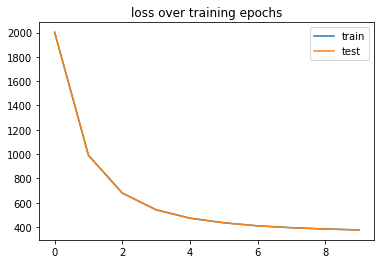

In [717]:
train = True
if train:
    # train the conditional VAE
    model = CondSCVI(sc_anndata, n_latent=3, n_layers=2, sparse=False, ct_prop=ct_prop)
    model.train(n_epochs=10, n_epochs_kl_warmup=5, frequency=1,)
#                 train_fun_kwargs={"alpha":0.00, "sparse_lr":0.01})
    plt.plot(model.history["elbo_train_set"][1:], label="train")
    plt.plot(model.history["elbo_test_set"][1:], label="test")
    plt.title("loss over training epochs")
    plt.legend()
    model.save("CondSCVI", overwrite=True)
else:
    model = CondSCVI.load("CondSCVI", sc_anndata, use_cuda=True)

In [718]:
sc_anndata.obsm["condi_latent_space"] = model.get_latent_representation(give_mean=True)

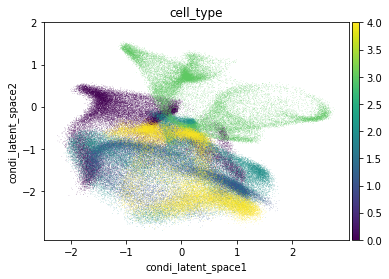

In [719]:
ax = sc.pl.embedding(sc_anndata, basis="condi_latent_space", frameon=True,
                color=["cell_type"], show=False)

ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_xticks([-2, -1, 0, 1, 2])
# ax.set_xlim([-3, 3])
# ax.set_ylim([-3, 3])
plt.show()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


<AxesSubplot:title={'center':'cell_type'}, xlabel='condi_latent_space1', ylabel='condi_latent_space2'>

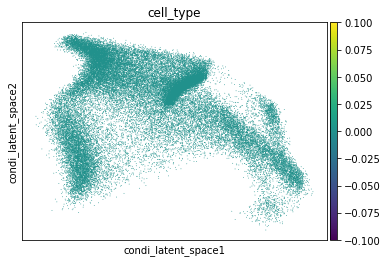

In [720]:
sc.pl.embedding(sc_anndata[sc_anndata.obs["cell_type"] == 0], basis="condi_latent_space", frameon=True,
                color=["cell_type"], show=False)

In [721]:
# lesson: maybe we shouldn't look at the gamma themselves,
# but just at the gene expression within each cell types of the spatial data and cluster that, then run DE

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


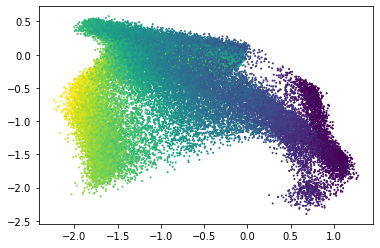

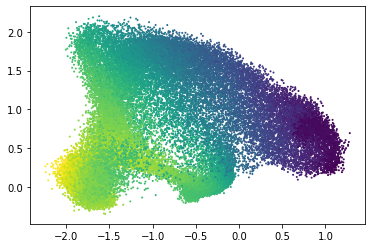

In [767]:
data_slice = sc_anndata[sc_anndata.obs["cell_type"] == 0]
plt.scatter(data_slice.obsm["condi_latent_space"][:, 0], 
            data_slice.obsm["condi_latent_space"][:, 1], 
            c=data_slice.obsm["gamma"][:, 0], s=1)
plt.show()
plt.scatter(data_slice.obsm["condi_latent_space"][:, 0], 
            data_slice.obsm["condi_latent_space"][:, 2], 
            c=data_slice.obsm["gamma"][:, 0], s=1)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


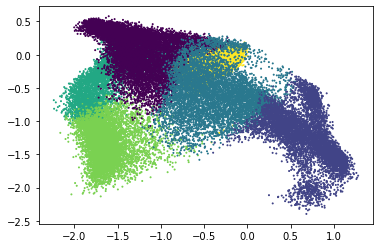

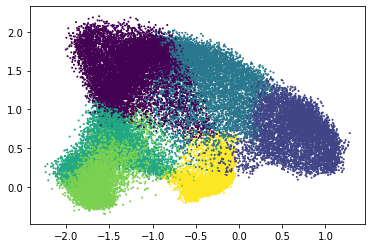

In [809]:
data_slice = sc_anndata[sc_anndata.obs["cell_type"] == 0]
plt.scatter(data_slice.obsm["condi_latent_space"][:, 0], 
            data_slice.obsm["condi_latent_space"][:, 1], 
            c=data_slice.obsm["hierarchical"][:, 2], s=1)
plt.show()
plt.scatter(data_slice.obsm["condi_latent_space"][:, 0], 
            data_slice.obsm["condi_latent_space"][:, 2], 
            c=data_slice.obsm["hierarchical"][:, 2], s=1)

In [723]:
ref_indices = []
p = 100
mean_vprior = np.zeros((n_labels, p, 3))
var_vprior = np.zeros((n_labels, p, 3))
for ct in range(n_labels):
    # pick 50 cells
    local_indices = np.random.choice(np.where(sc_anndata.obs["cell_type"] == ct)[0], p)
    ref_indices += list(local_indices)
    mean_vprior[ct], var_vprior[ct] =  model.get_vamp_prior(sc_anndata, local_indices)

In [724]:
mean_vprior.mean(1)

array([[-0.76803653, -0.46134538,  0.76157714],
       [-0.38121237, -1.55289189,  0.446341  ],
       [-0.26329467, -1.20382696,  0.9141333 ],
       [ 0.45521594,  0.09575408,  1.47983066],
       [ 0.09360753, -1.48593713,  0.38949846]])

In [725]:
var_vprior.mean(1)

array([[0.00701269, 0.00304926, 0.007474  ],
       [0.00987833, 0.02584795, 0.01333221],
       [0.00658062, 0.01118184, 0.01459916],
       [0.0024916 , 0.00097322, 0.00313322],
       [0.00970232, 0.02054629, 0.01260607]])

# deconvolve

In [726]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import stVI

In [727]:
# get dataset ready
scvi.data.setup_anndata(st_anndata)
st_anndata.obs["indices"] = np.arange(st_anndata.n_obs)
register_tensor_from_anndata(st_anndata, "ind_x", "obs", "indices")

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 1600 cells, 2000 genes, 1        
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [901]:
# now try to run the deconv algorithm on the spatial data
state_dict = (model.model.decoder.state_dict(), model.model.px_decoder.state_dict(), model.model.px_r.detach().cpu().numpy())
n_labels = sc_anndata.uns["_scvi"]["summary_stats"]["n_labels"]
spatial_model = stVI(st_anndata, n_labels, state_dict, None,
                    n_latent=3, n_hidden=128, n_layers=2, 
                     n_spots=st_anndata.n_obs, amortized=True,
                    mean_vprior=mean_vprior, var_vprior=var_vprior) 
                     #gamma=np.array(gamma_fixed[:, :, None].repeat(st_anndata.n_obs, axis=-1), dtype=np.float32))

TypeError: __init__() got an unexpected keyword argument 'mean_vprior'

In [729]:
spatial_model.train(lr=0.01, n_epochs=1500, frequency=5, train_size=1)

INFO      Training for 1500 epochs                                                           
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training time:  188 s. / 1500 epochs                                               


(array([368., 711., 380.,  99.,  25.,   5.,   8.,   3.,   0.,   1.]),
 array([0.00268115, 0.01242399, 0.02216682, 0.03190965, 0.04165249,
        0.05139532, 0.06113815, 0.07088098, 0.08062381, 0.09036665,
        0.10010948], dtype=float32),
 <BarContainer object of 10 artists>)

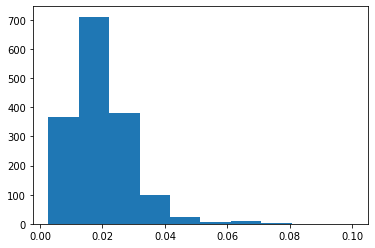

In [730]:
plt.hist(spatial_model.model.get_proportions(keep_noise=True)[:, -1])

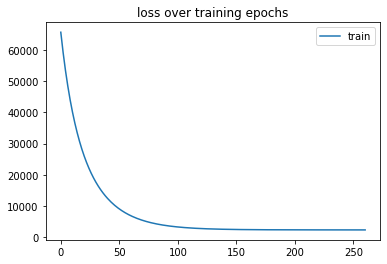

2305.1627241265724

In [731]:
plt.plot(spatial_model.history["elbo_train_set"][40:], label="train")
plt.title("loss over training epochs")
plt.legend()
plt.show()
spatial_model.history["elbo_train_set"][-1]

In [732]:
# get proportions
hstereo_proportions, hstereo_gamma = spatial_model.get_proportions(st_anndata)

In [733]:
hstereo_proportions

array([[8.43443334e-01, 9.98233631e-02, 1.92685390e-03, 1.70387848e-05,
        5.47893904e-02],
       [8.40178549e-01, 1.15911484e-01, 5.00100432e-04, 1.61292628e-05,
        4.33937311e-02],
       [7.92852998e-01, 1.51992366e-01, 9.41290241e-03, 1.33336121e-02,
        3.24081518e-02],
       ...,
       [6.18209727e-02, 1.12979874e-01, 5.28932130e-03, 4.15717930e-01,
        4.04191881e-01],
       [4.68322188e-02, 1.15499154e-01, 1.44866551e-03, 5.22997200e-01,
        3.13222736e-01],
       [4.36824746e-02, 1.74693682e-03, 3.96293253e-01, 3.09685946e-01,
        2.48591453e-01]], dtype=float32)

In [734]:
np.mean(hstereo_gamma, -1)

array([[-0.63317347, -0.08511445, -0.27595958,  0.07480113, -0.09887601],
       [-0.43189257, -1.5339311 , -0.9500368 ,  0.04049629, -0.94795114],
       [ 0.717566  ,  0.47330108,  0.6749676 ,  0.85882586,  0.28860745]],
      dtype=float32)

In [735]:
hstereo_gamma.shape

(3, 5, 1600)

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


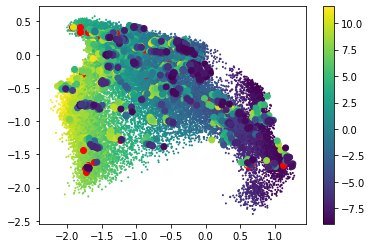

In [736]:
ct = 0
d1 = 0
d2 = 1
data_slice = sc_anndata[sc_anndata.obs["cell_type"] == ct]
plt.scatter(data_slice.obsm["condi_latent_space"][:, d1], 
            data_slice.obsm["condi_latent_space"][:, d2], 
            c=data_slice.obsm["gamma"][:, 0], s=1)
plt.colorbar()
plt.scatter(mean_vprior[ct, :, d1], mean_vprior[ct, :, d2], color="red")
plt.scatter(hstereo_gamma[d1, ct, :], hstereo_gamma[d2, ct, :], c=st_anndata.obsm["gamma"][:, 0])
plt.show()
plt.show()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


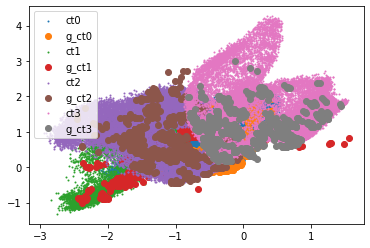

In [737]:
d1=1
d2=2
for i in range(4):
    data_slice = sc_anndata[sc_anndata.obs["cell_type"] == i]
    plt.scatter(data_slice.obsm["condi_latent_space"][:, d1], 
            data_slice.obsm["condi_latent_space"][:, d2], s=1, label="ct"+str(i))

    plt.scatter(hstereo_gamma[d1, i, :], 
            hstereo_gamma[d2, i, :], label="g_ct"+str(i) )
plt.legend()

/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


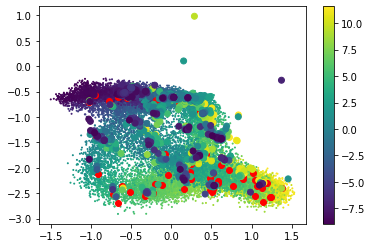

In [738]:
ct = 4
d1 = 0
d2 = 1
data_slice = sc_anndata[sc_anndata.obs["cell_type"] == ct]
plt.scatter(data_slice.obsm["condi_latent_space"][:, d1], 
            data_slice.obsm["condi_latent_space"][:, d2], 
            c=data_slice.obsm["gamma"][:, 0], s=1)
plt.colorbar()
plt.scatter(mean_vprior[ct, :, d1], mean_vprior[ct, :, d2], color="red")
plt.scatter(hstereo_gamma[d1, ct, :], hstereo_gamma[d2, ct, :], c=st_anndata.obsm["gamma"][:, 0])
plt.show()
plt.show()

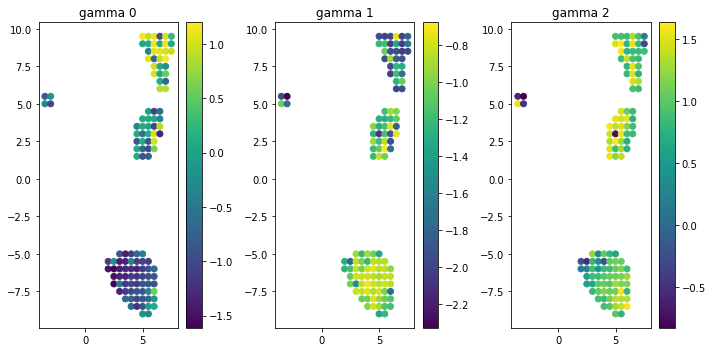

In [739]:
plt.figure(figsize=(10,5))
ct = 1
for i in range(3):
    plt.subplot(131 + i)
    filter_by_freq = st_anndata.obsm["cell_type"][:, ct] > 0.5
    plt.scatter(locations[filter_by_freq][:, 0], locations[filter_by_freq][:, 1], c=hstereo_gamma[i, ct, :][filter_by_freq])
    plt.title("gamma "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

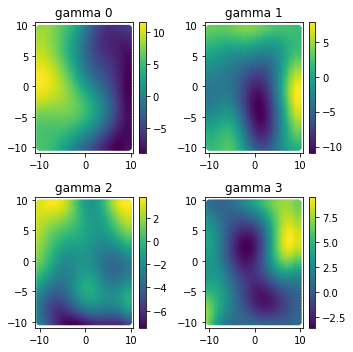

In [740]:
plt.figure(figsize=(5,5))
for i in range(D):
    plt.subplot(221 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=st_anndata.obsm["gamma"][:, i])
    plt.title("gamma "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

In [741]:
@jit(nopython=True)
def find_location_index_cell_type(locations, cell_type, loc_ref, ct_ref):
    """
    return the indices for locations in query only if cell type matches
    """
    out_a = [0]
    out_b = [0]
    for i in range(locations.shape[0]):
        for j in range(loc_ref.shape[0]):
            if np.all(locations[i] == loc_ref[j]):
                if cell_type == ct_ref[j]:
                    out_a += [i]
                    out_b += [j]
    return np.array(out_a[1:]), np.array(out_b[1:])

In [868]:
from scipy.stats import spearmanr, pearsonr
def metrics_expression_levels(groundtruth, proposed, scaling = 2e5, gene_list=None):
    # groundtruth should be of shape (n_spots, n_genes)
    n_spots, n_genes = groundtruth.shape
    res = {}
    # correlations metrics
    if gene_list is None:
        print("ALL GENES")
        gene_list = range(n_genes)
    res["avg_spearman"] = np.mean([spearmanr(groundtruth[:, gene] + np.random.normal(0, 1e-18, size=n_spots), proposed[:, gene]).correlation for gene in gene_list])
    res["avg_pearson"] = np.mean([pearsonr(groundtruth[:, gene] + np.random.normal(0, 1e-18, size=n_spots), proposed[:, gene])[0] for gene in gene_list])
    # error metrics
    res["median_l1"] = np.median(np.abs(scaling * groundtruth - scaling * proposed)[:, gene_list])
    res["mse"] = np.sqrt(np.mean((scaling* groundtruth - scaling * proposed)[:, gene_list]**2))
    return res

In [869]:
# get gene expression from the model
# for each cell type, query the model at certain locations and compare to groundtruth
imputed_normalized_expression = np.zeros_like(grtruth_expr.f.s_normalized)
for ct in mapping:
    out_a, out_b = find_location_index_cell_type(st_anndata.obsm["locations"], ct, 
                                        grtruth_expr.f.s_location, grtruth_expr.f.s_ct)
    ind_x = out_a[:, np.newaxis].astype(np.long)
    y = ct * np.ones((out_a.shape[0], 1), np.long)
    expression = spatial_model.get_scale_for_ct(ind_x, y)
    normalized_expression = expression / np.sum(expression, axis=1)[:, np.newaxis]
    # get local scores
    indices_gt = np.where(grtruth_expr.f.s_ct == ct)[0]
    normalized_grountruth = grtruth_expr.f.s_normalized[indices_gt, :]
    # filter genes for local scores only
    gene_list = np.unique(np.hstack([np.where(components_[ct, i] != 0)[0] for i in range(D)]))
    res = metrics_expression_levels(normalized_grountruth, normalized_expression, gene_list=gene_list)
    print(ct, res)
    # flush to global
    imputed_normalized_expression[indices_gt] = normalized_expression
metrics_expression_levels(grtruth_expr.f.s_normalized, imputed_normalized_expression)

0 {'avg_spearman': 0.5771998752281582, 'avg_pearson': 0.5569317129074195, 'median_l1': 1.2569209765496234, 'mse': 141.76950634237252}
1 {'avg_spearman': 0.42383810307449976, 'avg_pearson': 0.41900880812642677, 'median_l1': 5.472392607877229, 'mse': 42.991634801249596}
2 {'avg_spearman': 0.615370969749703, 'avg_pearson': 0.6292423944435183, 'median_l1': 4.003646613012791, 'mse': 71.92424624730043}
3 {'avg_spearman': 0.5655710118133713, 'avg_pearson': 0.6359102433983811, 'median_l1': 6.9017198202030166, 'mse': 620.5325336783927}
4 {'avg_spearman': 0.44531769857168385, 'avg_pearson': 0.43410221969250457, 'median_l1': 6.098198002595932, 'mse': 101.01030943134758}
ALL GENES


{'avg_spearman': 0.6136699154821021,
 'avg_pearson': 0.7765985792546745,
 'median_l1': 0.6628181827396247,
 'mse': 135.72314979148675}

## Stereoscope broad clusters

In [744]:
from scvi.model.stereoscope import scStereoscope, stStereoscope

In [745]:
scvi.data.setup_anndata(sc_anndata, labels_key="cell_type")
sc_anndata.obs["indices"] = np.arange(sc_anndata.n_obs)
register_tensor_from_anndata(sc_anndata, "ind_x", "obs", "indices")

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      Using labels from adata.obs["cell_type"]                                           
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO      Successfully registered anndata object containing 160000 cells, 2000 genes, 1      
          batches, 5 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


In [746]:
sc_stereo = scStereoscope(sc_anndata, )
sc_stereo.train(lr=0.01, n_epochs=10, frequency=1)

INFO      Training for 10 epochs                                                             
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  63 s. / 10 epochs                                                  


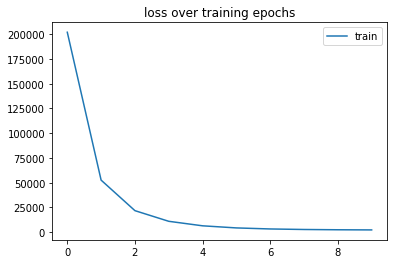

2247.359425564236

In [747]:
plt.plot(sc_stereo.history["elbo_train_set"][1:], label="train")
plt.title("loss over training epochs")
plt.legend()
plt.show()
sc_stereo.history["elbo_train_set"][-1]

In [748]:
params = sc_stereo.get_params()

In [749]:
# get dataset ready
scvi.data.setup_anndata(st_anndata)
st_anndata.obs["indices"] = np.arange(st_anndata.n_obs)
register_tensor_from_anndata(st_anndata, "ind_x", "obs", "indices")

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      No label_key inputted, assuming all cells have same label                          
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             
INFO      Successfully registered anndata object containing 1600 cells, 2000 genes, 1        
          batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates  
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [750]:
st_stereo = stStereoscope(st_anndata, params)
st_stereo.train(lr=0.01, n_epochs=1000, train_size=1, frequency=5)

INFO      Training for 1000 epochs                                                           
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training time:  73 s. / 1000 epochs                                                


In [751]:
def safe_softplus(x):
    inRanges = (x < 30)
    return np.log(1 + np.exp(x*inRanges))*inRanges + x*(1-inRanges)

(array([1.959e+03, 3.000e+01, 5.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([1.96795183e-04, 6.67511587e-02, 1.33305522e-01, 1.99859886e-01,
        2.66414249e-01, 3.32968613e-01, 3.99522976e-01, 4.66077340e-01,
        5.32631703e-01, 5.99186067e-01, 6.65740430e-01]),
 <BarContainer object of 10 artists>)

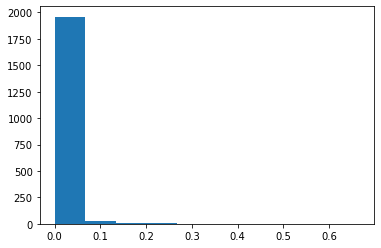

In [752]:
plt.hist(safe_softplus(st_stereo.model.eta.detach().cpu().numpy()))

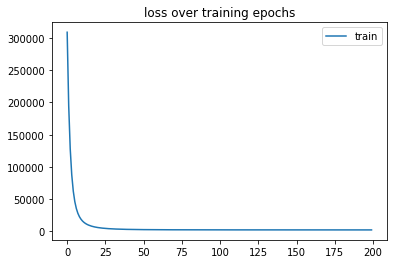

2237.3310095214842

In [753]:
plt.plot(st_stereo.history["elbo_train_set"][1:], label="train")
plt.title("loss over training epochs")
plt.legend()
plt.show()
st_stereo.history["elbo_train_set"][-1]

In [754]:
stereo_proportions = st_stereo.get_proportions()

In [755]:
st_stereo.model.get_proportions(keep_noise=True)[:, -1]

array([0.01692265, 0.02952626, 0.03709728, ..., 0.02067836, 0.01878786,
       0.03527027], dtype=float32)

In [855]:
# get gene expression from the model
# for each cell type, query the model at certain locations and compare to groundtruth
imputed_normalized_expression = np.zeros_like(grtruth_expr.f.s_normalized)
for ct in mapping:
    out_a, out_b = find_location_index_cell_type(st_anndata.obsm["locations"], ct, 
                                        grtruth_expr.f.s_location, grtruth_expr.f.s_ct)
    ind_x = out_a[:, np.newaxis].astype(np.long)
    y = ct * np.ones((out_a.shape[0], 1), np.long)
    expression = st_stereo.get_scale_for_ct(ind_x, y)
    normalized_expression = expression / np.sum(expression, axis=1)[:, np.newaxis]
    # get local scores
    indices_gt = np.where(grtruth_expr.f.s_ct == ct)[0]
    normalized_grountruth = grtruth_expr.f.s_normalized[indices_gt, :]
    # filter genes for local scores only
    gene_list = np.unique(np.hstack([np.where(components_[ct, i] != 0)[0] for i in range(D)]))
    res = metrics_expression_levels(normalized_grountruth, normalized_expression, gene_list=gene_list)
    print(ct, res)
    # flush to global
    imputed_normalized_expression[indices_gt] = normalized_expression
metrics_expression_levels(grtruth_expr.f.s_normalized, imputed_normalized_expression)

RuntimeError: Please train the model first.

## Stereoscope + clustering

In [871]:
# form cell types into anndata object
depth_clustering = 2
base_cell_type = sc_anndata.obs["cell_type"]
sub_cell_type = sc_anndata.obsm["hierarchical"][:, depth_clustering]
nb_sub_ct = len(np.unique(sub_cell_type))

In [872]:
all_cell_type = np.array([base_cell_type[i] * nb_sub_ct + sub_cell_type[i] for i in range(sc_anndata.n_obs)])
sc_anndata.obs["all_cell_type"] = all_cell_type.astype(np.int)

In [873]:
sc_anndata.obs["all_cell_type"].value_counts()

0     9714
5     8077
18    7036
10    6991
2     6830
28    6711
1     6624
4     6530
17    6487
13    6335
3     5930
7     5574
23    5373
12    5076
26    4993
25    4862
19    4824
22    4707
8     4677
15    4586
16    4566
24    4274
14    4010
21    3837
29    3767
9     3717
6     3694
27    3605
20    3396
11    3197
Name: all_cell_type, dtype: int64

In [874]:
scvi.data.setup_anndata(sc_anndata, labels_key="all_cell_type")
sc_anndata.obs["indices"] = np.arange(sc_anndata.n_obs)
register_tensor_from_anndata(sc_anndata, "ind_x", "obs", "indices")

INFO      No batch_key inputted, assuming all cells are same batch                           
INFO      Using labels from adata.obs["all_cell_type"]                                       
INFO      Using data from adata.X                                                            
INFO      Computing library size prior per batch                                             


/home/ubuntu/anaconda3/envs/scVI/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


INFO      Successfully registered anndata object containing 160000 cells, 2000 genes, 1      
          batches, 30 labels, and 0 proteins. Also registered 0 extra categorical covariates 
          and 0 extra continuous covariates.                                                 
INFO      Please do not further modify adata until model is trained.                         


In [875]:
hsc_stereo = scStereoscope(sc_anndata, )
hsc_stereo.train(lr=0.01, n_epochs=10, frequency=1)

INFO      Training for 10 epochs                                                             
INFO      KL warmup phase exceeds overall training phaseIf your applications rely on the     
          posterior quality, consider training for more epochs or reducing the kl warmup.    
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training is still in warming up phase. If your applications rely on the posterior  
          quality, consider training for more epochs or reducing the kl warmup.              
INFO      Training time:  61 s. / 10 epochs                                                  


In [876]:
params = hsc_stereo.get_params()

In [881]:
hst_stereo = stStereoscope(st_anndata, params)
hst_stereo.train(lr=0.01, n_epochs=1000, train_size=1, frequency=5)

INFO      Training for 1000 epochs                                                           
INFO      KL warmup for 400 epochs                                                           


Output()

INFO      Training time:  76 s. / 1000 epochs                                                


In [882]:
hstereo_proportions = hst_stereo.get_proportions()

In [883]:
hstereo_proportions.shape

(1600, 30)

In [896]:
hstereo_proportions[:, 1::nb_sub_ct]

array([[9.92768481e-02, 1.58933345e-02, 9.82269924e-03, 6.81600359e-05,
        9.73335467e-03],
       [9.31683332e-02, 3.19270827e-02, 1.14536053e-02, 1.73257035e-03,
        2.45660986e-03],
       [8.81239027e-02, 5.49198240e-02, 1.20086465e-02, 2.74355384e-03,
        2.34315568e-03],
       ...,
       [2.57275738e-02, 1.70176346e-02, 3.38942558e-02, 6.11549430e-02,
        6.83437884e-02],
       [1.48509378e-02, 1.95417125e-02, 3.61837000e-02, 6.30196929e-02,
        6.31714985e-02],
       [1.28965322e-02, 4.23299856e-02, 5.90105653e-02, 4.85104136e-02,
        5.80962002e-02]], dtype=float32)

In [888]:
agg_hstereo_proportions = hstereo_proportions[:, ::nb_sub_ct]
for i in range(1, nb_sub_ct):
    agg_hstereo_proportions += hstereo_proportions[:, i::nb_sub_ct]

In [885]:
# get gene expression from the model
# for each cell type, query the model at certain locations and compare to groundtruth
imputed_normalized_expression = np.zeros_like(grtruth_expr.f.s_normalized)
for ct in mapping:
    out_a, out_b = find_location_index_cell_type(st_anndata.obsm["locations"], ct, 
                                        grtruth_expr.f.s_location, grtruth_expr.f.s_ct)
    ind_x = out_a[:, np.newaxis].astype(np.long)
    # here we must predict the cell type based on the max
    y = hstereo_proportions[ind_x[:, 0], nb_sub_ct*ct:nb_sub_ct*ct+nb_sub_ct].argmax(1) + nb_sub_ct * ct
    # TODO REPLACE BY THE MEAN -> alg must pay for high uncertainty
    expression = hst_stereo.get_scale_for_ct(ind_x, y[:, np.newaxis])
    normalized_expression = expression / np.sum(expression, axis=1)[:, np.newaxis]
    # get local scores
    indices_gt = np.where(grtruth_expr.f.s_ct == ct)[0]
    normalized_grountruth = grtruth_expr.f.s_normalized[indices_gt, :]
    # filter genes for local scores only
    gene_list = np.unique(np.hstack([np.where(components_[ct, i] != 0)[0] for i in range(D)]))
    res = metrics_expression_levels(normalized_grountruth, normalized_expression, gene_list=gene_list)
    print(ct, res)
    # flush to global
    imputed_normalized_expression[indices_gt] = normalized_expression
metrics_expression_levels(grtruth_expr.f.s_normalized, imputed_normalized_expression)

0 {'avg_spearman': 0.4470207266375047, 'avg_pearson': 0.5071689491975254, 'median_l1': 1.5219694225844194, 'mse': 434.0275628597537}
1 {'avg_spearman': 0.5392636228999875, 'avg_pearson': 0.5833977208926073, 'median_l1': 3.7793603372455227, 'mse': 49.88420289465974}
2 {'avg_spearman': 0.7288052549165328, 'avg_pearson': 0.7588179374590753, 'median_l1': 3.0980970090049027, 'mse': 222.8532229682213}
3 {'avg_spearman': 0.5585895962065921, 'avg_pearson': 0.6892053253795372, 'median_l1': 6.149058871563773, 'mse': 764.4918200754737}
4 {'avg_spearman': 0.6620984055611241, 'avg_pearson': 0.6481489650182881, 'median_l1': 4.1191754651849415, 'mse': 377.1782482172089}
ALL GENES


{'avg_spearman': 0.5382363842666604,
 'avg_pearson': 0.6788236230023054,
 'median_l1': 0.9049483024962496,
 'mse': 286.72797253914143}

## comparaison

Groundtruth


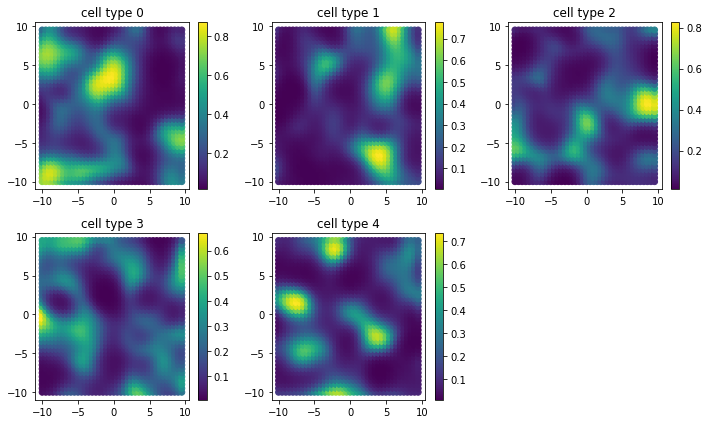

In [886]:
plt.figure(figsize=(10,6))
print("Groundtruth")
for i in range(0, 5):
    plt.subplot(231 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=st_anndata.obsm["cell_type"][:, i])
    plt.title("cell type "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

Stereoscope


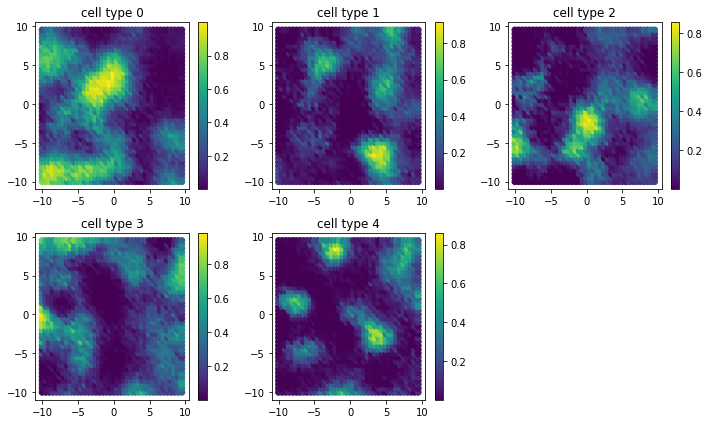

In [887]:
plt.figure(figsize=(10,6))
print("Stereoscope")
for i in range(0, 5):
    plt.subplot(231 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=stereo_proportions[:, i])
    plt.title("cell type "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

HStereoscope


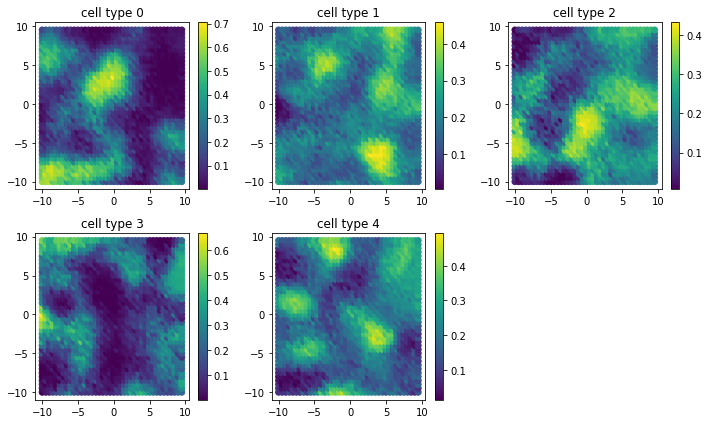

In [897]:
plt.figure(figsize=(10,6))
print("HStereoscope")
for i in range(0, 5):
    plt.subplot(231 + i)
    plt.scatter(locations[:, 0], locations[:, 1], c=agg_hstereo_proportions[:, i])
    plt.title("cell type "+str(i))
    plt.colorbar()
plt.tight_layout()
plt.show()

In [832]:
from scipy.stats import spearmanr, pearsonr
def metrics_proportions(groundtruth, proposed):
    # groundtruth should be of shape (n_spots, n_labels)
    n_spots, n_labels = groundtruth.shape
    res = {}
    # correlations metrics
    res["avg_spearman"] = np.mean([spearmanr(groundtruth[:, ct], proposed[:, ct]).correlation for ct in range(n_labels)])
    res["avg_pearson"] = np.mean([pearsonr(groundtruth[:, ct], proposed[:, ct])[0] for ct in range(n_labels)])
    # error metrics
    res["median_l1"] = np.median(np.abs(groundtruth - proposed))
    res["mse"] = np.sqrt(np.mean((groundtruth - proposed)**2))
    return res

In [833]:
metrics_proportions(st_anndata.obsm["cell_type"], stereo_proportions)

{'avg_spearman': 0.837521499813086,
 'avg_pearson': 0.8810079093563796,
 'median_l1': 0.05362949441537293,
 'mse': 0.09835881271178504}

In [899]:
metrics_proportions(st_anndata.obsm["cell_type"], agg_hstereo_proportions)

{'avg_spearman': 0.8312147468960266,
 'avg_pearson': 0.8551977432852962,
 'median_l1': 0.05754311059909315,
 'mse': 0.09710659883951724}